# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Initializing all libraries

In [1]:
#References
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from joblib import dump, load
from sklearn.model_selection import GridSearchCV

% matplotlib inline


#### Data fetch from json file using pandas read_json()
### Reading the data from portfolio, profile and transcript json files and making a copy to keep original for future reference



In [2]:


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


portfolio_original = portfolio.copy()
profile_original = profile.copy()
transcript_original = transcript.copy()



#### Data explorations
### Portfolio (Offer Details)


portfolio.json

    id (string) - offer id
    offer_type (string) - type of offer ie BOGO, discount, informational
    difficulty (int) - minimum required spend to complete an offer
    reward (int) - reward given for completing an offer
    duration (int) - time for offer to be open, in days
    channels (list of strings)
 
 
 Information given about the offers is that there are 3 different offer types:

    BOGO - buy one get one free
    Discount - discount with purchase
    Informational - provides information about products



In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

### There is no null values in portfolio database

### Cleansing Portfolio
 Rename the id column to "offer_id"
 
 converting offer type to numerical type by pd.get_dummies
 
 Extract channels to numerical type by MultiLabelBinarizer

In [6]:
#rename column
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [7]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [8]:
 # One hot encode the 'offertype' column
offertype_df = pd.get_dummies(portfolio['offer_type'])

In [9]:
# One hot encode the 'channels' columns
ml_binarizerobj = MultiLabelBinarizer()
ml_binarizerobj.fit(portfolio['channels'])

channels_df = pd.DataFrame(ml_binarizerobj.transform(portfolio['channels']),columns=ml_binarizerobj.classes_)


In [10]:
portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

In [11]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


In [12]:
portfolio.drop(columns=['offer_type', 'channels'],inplace=True)

In [13]:
portfolio.head()

,difficulty,duration,offer_id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1



### Demographic data

Demographic data for customers is provided in the profile dataset. The schema and variables are as follows:

profile.json

    age (int) - age of the customer
    became_member_on (int) - date when customer created an app account
    gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
    id (str) - customer id
    income (float) - customer's income

It contains the demographic profile of a  customer.


In [14]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
profile.rename(columns={'id':'customer_id'},inplace=True)

In [16]:
profile.shape

(17000, 5)

In [17]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89c48c67f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f89c4822a20>]], dtype=object)

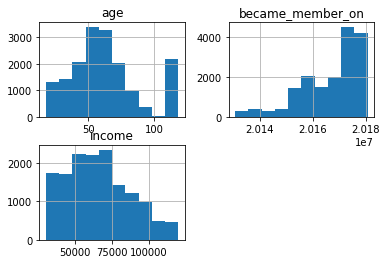

In [18]:
profile.hist()

from the above age histogram, there is an outlier, we need to fix the outlier otherwise it will be 
an issue in predicting. 

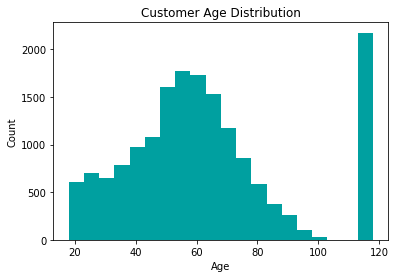

In [19]:
# Age distribution
plt.hist(profile.age, bins = 20, color = '#00A0A0');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age Distribution');

The indivuduals with age above 100 is an outlier which affects our prediction. So we are avoiding those individuals

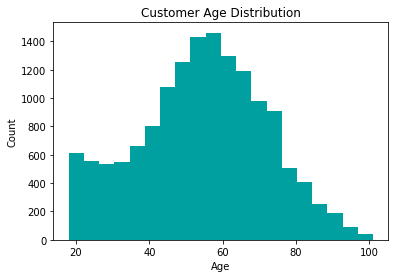

In [20]:
plt.hist(profile[profile.age < 118].age, bins = 20, color = '#00A0A0');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age Distribution');

Now the graph looks like a symmetrical graph

In [21]:
profile[['gender','income','age']][profile['age']==118].head()

,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


#### if you see all those have age 118 , there is no gender or income. We have to fill or drop based on the size of data

In [22]:
profile.isnull().sum()/profile.shape[0]*100

age                  0.000000
became_member_on     0.000000
gender              12.794118
customer_id          0.000000
income              12.794118
dtype: float64

In [23]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

In [24]:
profile=profile[profile['income'].notnull()]


In [25]:
profile['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

In [26]:
profile[profile['gender']=='O'].count()

age                 212
became_member_on    212
gender              212
customer_id         212
income              212
dtype: int64

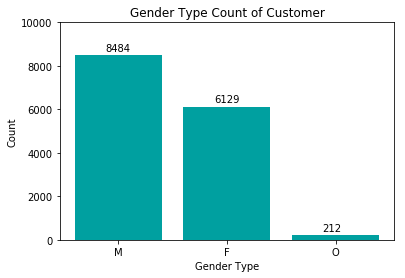

In [27]:
# Look into gender ratio
gender = pd.DataFrame(profile.gender.value_counts())
plt.bar(range(gender.shape[0]), gender.values.reshape(1, -1)[0], color = '#00A0A0');
plt.xticks(range(gender.shape[0]), gender.index);
for i in range(gender.shape[0]):
    plt.text(i-0.12, gender.values.reshape(1, -1)[0][i]+200, gender.values.reshape(1, -1)[0][i]);
plt.ylim(0, 10000);
plt.xlabel('Gender Type');
plt.ylabel('Count');
plt.title('Gender Type Count of Customer');

We have more male customers in the data

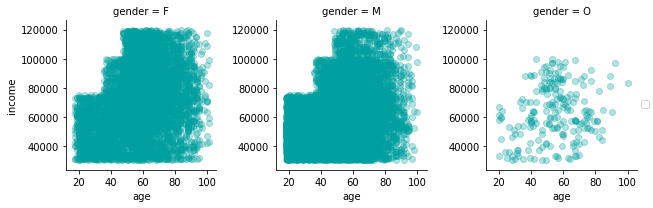

In [28]:
# visualize the 3 factors'(age, income ,gender) relationship
g = sns.FacetGrid(data = profile, col = 'gender');
g.map(plt.scatter, 'age', 'income', alpha=0.3, color = '#00A0A0');
g.add_legend();

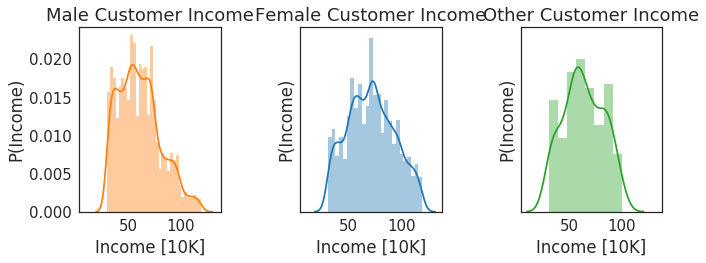

In [29]:
male_customers = profile[profile['gender'] == 'M']
female_customers = profile[profile['gender'] == 'F']
other_customers=profile[profile['gender'] == 'O']
current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=3,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')

plt.sca(ax[2])
sns.distplot(other_customers['income'] * 1E-3,
             color=current_palette[2])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Other Customer Income')



plt.tight_layout()

In [30]:
profile.head()

,age,became_member_on,gender,customer_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


#### become_member_on  column we can split into year, month and date. It will help for feature engineering

In [31]:
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    
    INPUT:
        elem: String that stores a date in the %Y%m%d format
    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [32]:
 # Transform the 'became_member_on' column to a datetime object
profile['became_member_on'] =profile['became_member_on'].apply(convert_to_datetime)

    # One hot encode a customer's membership start year
profile['membershipstartyear'] =profile['became_member_on'].apply(lambda elem: elem.year)
profile['membershipstartMonth'] =profile['became_member_on'].apply(lambda elem: elem.month)
profile['membershipstartday'] =profile['became_member_on'].apply(lambda elem: elem.day)


In [33]:
profile.head()

,age,became_member_on,gender,customer_id,income,membershipstartyear,membershipstartMonth,membershipstartday
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11


In [34]:
profile.describe()

,age,income,membershipstartyear,membershipstartMonth,membershipstartday
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,2016.620169,6.695582,15.904013
std,17.383705,21598.299410,1.198245,3.488853,8.747571
min,18.000000,30000.000000,2013.000000,1.000000,1.000000
25%,42.000000,49000.000000,2016.000000,4.000000,8.000000
50%,55.000000,64000.000000,2017.000000,7.000000,16.000000
75%,66.000000,80000.000000,2017.000000,10.000000,23.000000
max,101.000000,120000.000000,2018.000000,12.000000,31.000000


Grouping the individuals by age

Find the max and min limit of the age and use "pd.cut" for gruping

In [35]:
# One hot encode a customer's age range
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)
print(min_age_limit)
print(max_age_limit)

10
110


In [36]:
print(range(min_age_limit,max_age_limit , 10))

range(10, 110, 10)


In [37]:
profile['agerange'] = pd.cut(profile['age'],(range(min_age_limit,max_age_limit +10, 10)),right=False)
profile['agerange'] = profile['agerange'].astype('str')

agerange_df = pd.get_dummies(profile['agerange'])

In [38]:
profile = pd.concat([profile,agerange_df], axis=1)


In [39]:
profile.head()

,age,became_member_on,gender,customer_id,income,membershipstartyear,membershipstartMonth,membershipstartday,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,"[50, 60)",0,0,0,0,0,1,0,0,0,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,"[70, 80)",0,0,0,0,0,0,0,1,0,0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,"[60, 70)",0,0,0,0,0,0,1,0,0,0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,"[60, 70)",0,0,0,0,0,0,1,0,0,0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0


In [40]:
gender_df = pd.get_dummies(profile['gender'])

In [41]:
profile = pd.concat([profile,gender_df], axis=1)

In [42]:
profile.head()

,age,became_member_on,gender,customer_id,income,membershipstartyear,membershipstartMonth,membershipstartday,agerange,"[10, 20)",...,"[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)",F,M,O
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,"[50, 60)",0,...,0,0,1,0,0,0,0,1,0,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,"[70, 80)",0,...,0,0,0,0,1,0,0,1,0,0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,"[60, 70)",0,...,0,0,0,1,0,0,0,0,1,0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,"[60, 70)",0,...,0,0,0,1,0,0,0,0,1,0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,"[50, 60)",0,...,0,0,1,0,0,0,0,0,1,0


In [43]:
profile.drop(columns=['became_member_on','agerange','gender'],inplace=True)

In [44]:
profile.head()

,age,customer_id,income,membershipstartyear,membershipstartMonth,membershipstartday,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)",F,M,O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0,0,0,0,0,1,0,0,0,0,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,0,0,0,0,0,0,0,1,0,0,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,0,0,0,0,0,0,1,0,0,0,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,0,0,0,0,0,0,1,0,0,0,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,0,0,0,0,0,1,0,0,0,0,0,1,0


In [45]:
profile.customer_id.nunique()

14825

#### Transactional records

The schema for the transactional data is as follows:

transcript.json

    event (str) - record description (ie transaction, offer received, offer viewed, etc.)
    person (str) - customer id
    time (int) - time in hours. The data begins at time t=0
    value - (dict of strings) - either an offer id or transaction amount depending on the record


In [46]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [47]:
transcript.rename(columns={'person':'customer_id'},inplace=True)

In [48]:
transcript.shape

(306534, 4)

In [49]:
transcript.isnull().sum()

event          0
customer_id    0
time           0
value          0
dtype: int64

In [50]:
# Remove customer id's that are not in the customer profile DataFrame
select_data = transcript['customer_id'].isin(profile['customer_id'])
transcript = transcript[select_data]

In [51]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [52]:
transcript.customer_id.nunique()

14825

#### So profile sum and person sum are same

In [53]:
percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
print("Percentage of transactions removed: %.2f %%" % percent_removed)

Percentage of transactions removed: 11.02 %


#### Since value column itself is like a {key,value} pair we have to extract and convert into columns. 
For that we are using pandas.Series

In [54]:
transcript['value'].apply(pd.Series)

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
5,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
7,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
12,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
13,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
14,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
15,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN


In [55]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,customer_id,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


#### From the above, offer id is duplicated. We have to combine both column to one

In [56]:
np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '2906b810c7d4411798c6938adc9daaa5',
       'f19421c1d4aa40978ebb69ca19b0e20d', ..., nan, nan, nan], dtype=object)

In [57]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [58]:
transcript.head(-10)

,event,customer_id,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,3f207df678b143eea3cee63160fa8bed
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
15,offer received,f806632c011441378d4646567f357a21,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [59]:
transcript['time']/=24

In [60]:
transcript.head(-10)

,event,customer_id,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0.00,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0.00,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.00,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.00,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0.00,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0.00,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0.00,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,3f207df678b143eea3cee63160fa8bed
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0.00,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
15,offer received,f806632c011441378d4646567f357a21,0.00,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [61]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [62]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts



,event,count
0,transaction,123957
1,offer received,66501
2,offer viewed,49860
3,offer completed,32444


Identifying percentage of offer and percentage of transaction happened

In [63]:
total_transactions = event_counts['count'].sum()

percentage_transactions = 100 * event_counts.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_counts.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.4 %
Percentage of customer offer events: 54.6 %


Convert Event column to numerical by pd.get_dummies

In [64]:
event_df = pd.get_dummies(transcript['event'])
   
# Create a DataFrame that describes customer offer events
transcript = pd.concat([transcript, event_df], axis=1)

In [65]:
transcript.head()

,event,customer_id,time,value,amount,reward,offer_id,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [66]:
transcript.rename(columns={'offer completed':'completed','offer received':'received','offer viewed':'viewed'},inplace=True)

In [67]:
transcript.drop(columns=['event','value'],inplace=True)

In [68]:
transcript.head()

,customer_id,time,amount,reward,offer_id,completed,received,viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [69]:
offer_data=transcript.drop(columns=['amount','reward','transaction'])

In [70]:
offer_data.head()

,customer_id,time,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
2,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [71]:
transcript.head()

,customer_id,time,amount,reward,offer_id,completed,received,viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [72]:
transaction_data=transcript.drop(columns=['reward','offer_id','completed','received','viewed'])

In [73]:
transaction_data.head()

,customer_id,time,amount,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,0
5,389bc3fa690240e798340f5a15918d5c,0.0,NaN,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,0


In [74]:
transaction_data=transaction_data[transaction_data['transaction']==1]

In [75]:
transaction_data.head()

,customer_id,time,amount,transaction
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56,1
12659,54890f68699049c2a04d415abc25e717,0.0,13.23,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51,1
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97,1


In [76]:
offer_data['customer_id'].nunique()

14825

In [77]:
customerid_list = offer_data['customer_id'].unique()

Identifiying an offer is a Successfull offer or Not

For each customerID from customer transaction data, apply the following algorithm:

    Select a customer's profile
    Select offer data for a specific customer
    Select transactions for a specific customer
    Initialize DataFrames that describe when a customer receives, views, and completes an offer
           check the recevied offer ID has been viewed and completed then it is a successfull offer


In [78]:
for id in range(len(customerid_list)):
    print(id)
    customerid = customerid_list[id]
    cur_customer = profile[profile['customer_id'] == customerid]
    print('====customer profile========')
    print(cur_customer)
    print('====offer data========')
    select_offer_data = offer_data['customer_id'] == customerid
    customer_offer_data = offer_data[select_offer_data]
    print(customer_offer_data)
    print('=====transaction data=======')
    select_transaction = transaction_data['customer_id'] == customerid
    customer_transaction_data = transaction_data[select_transaction]
    print(customer_transaction_data)
    
    event_type = ['completed',
                  'received',
                  'viewed']
    print('======offer received======')
    offer_received = customer_offer_data[customer_offer_data['received'] == 1]
    
    print(offer_received)
    

    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    offer_viewed =customer_offer_data[customer_offer_data['viewed'] == 1]

    print('======offer viewed======')
    print(offer_viewed)
    
    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    offer_completed =  customer_offer_data[customer_offer_data['completed'] == 1]

    print('=====offer completed=======')
    print(offer_completed)
    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)
    
    rows = []
    for idx in range(offer_received.shape[0]):

        # Initialize the current offer id
        cur_offer_id = offer_received.iloc[idx]['offer_id']
        print("current offer id "+cur_offer_id)
        
        
        count_offer_viewed=len(offer_viewed.loc[offer_viewed['offer_id'] == cur_offer_id])
        
        print('=======')
        Count_offer_completed=len(offer_completed.loc[offer_completed['offer_id'] == cur_offer_id])
        print('Next')
        cur_offer_successful=0
        if (count_offer_viewed==1):
            if (Count_offer_completed==1):
                cur_offer_successful=1
        print("successful transaction==> "+np.str(cur_offer_successful))         
    break

0
====customer profile========
   age                       customer_id    income  membershipstartyear  \
3   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0                 2017   

   membershipstartMonth  membershipstartday  [10, 20)  [100, 110)  [20, 30)  \
3                     5                   9         0           0         0   

   [30, 40)  [40, 50)  [50, 60)  [60, 70)  [70, 80)  [80, 90)  [90, 100)  F  \
3         0         0         0         0         1         0          0  1   

   M  O  
3  0  0  
====offer data========
                             customer_id   time  \
0       78afa995795e4d85b5d9ceeca43f5fef   0.00   
15561   78afa995795e4d85b5d9ceeca43f5fef   0.25   
47582   78afa995795e4d85b5d9ceeca43f5fef   5.50   
47583   78afa995795e4d85b5d9ceeca43f5fef   5.50   
49502   78afa995795e4d85b5d9ceeca43f5fef   6.00   
53176   78afa995795e4d85b5d9ceeca43f5fef   7.00   
85291   78afa995795e4d85b5d9ceeca43f5fef   9.00   
87134   78afa995795e4d85b5d9ceeca43f5fef   9.25  

below is the another method to identify an offer is a Successfull offer or Not

For each customerID from customer transaction data, apply the following algorithm:

    Select a customer's profile
    Select offer data for a specific customer
    Select transactions for a specific customer
    Initialize DataFrames that describe when a customer receives, views, and completes an offer
        here we are calculating the start time and end time of an offer
        checking whether the transaction happened with in the time frame. This is more accurate than above

In [79]:
for id in range(len(customerid_list)):
    print(id)
    customerid = customerid_list[id]
    cur_customer = profile[profile['customer_id'] == customerid]
    print('====customer profile========')
    print(cur_customer)
    print('====offer data========')
    select_offer_data = offer_data['customer_id'] == customerid
    customer_offer_data = offer_data[select_offer_data]
    print(customer_offer_data)
    print('=====transaction data=======')
    select_transaction = transaction_data['customer_id'] == customerid
    customer_transaction_data = transaction_data[select_transaction]
    print(customer_transaction_data)
    
    event_type = ['completed',
                  'received',
                  'viewed']
    print('======offer received======')
    offer_received = customer_offer_data[customer_offer_data['received'] == 1]
    
    print(offer_received)
    

    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    offer_viewed =customer_offer_data[customer_offer_data['viewed'] == 1]

    print('======offer viewed======')
    print(offer_viewed)
    
    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    offer_completed =  customer_offer_data[customer_offer_data['completed'] == 1]

    print('=====offer completed=======')
    print(offer_completed)
    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)
    
    rows = []
    for idx in range(offer_received.shape[0]):

        # Initialize the current offer id
        cur_offer_id = offer_received.iloc[idx]['offer_id']
        print("current offer id "+cur_offer_id)
        
       # Look-up a description of the current offer
        cur_offer = portfolio.loc[portfolio['offer_id'] == cur_offer_id]
        durationdays = cur_offer['duration'].values[0]

       
        cur_offer_startime = offer_received.iloc[idx]['time']

        cur_offer_endtime = offer_received.iloc[idx]['time'] + durationdays

       
        select_transaction = np.logical_and(customer_transaction_data['time'] >=
                                                   cur_offer_startime,
                                                   customer_transaction_data['time'] <=
                                                   cur_offer_endtime)

        select_offer_completed =np.logical_and(offer_completed['time'] >= cur_offer_startime,
                                           offer_completed['time'] <= cur_offer_endtime)

        
        select_offer_viewed = np.logical_and(offer_viewed['time'] >= cur_offer_startime,
                                           offer_viewed['time'] <= cur_offer_endtime)

       
        cur_offer_successful = select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

       
        cur_offer_transactions = customer_transaction_data[select_transaction]

        cur_row = {'offerid': cur_offer_id,
                   'customerid': customerid,
                   'time': cur_offer_startime,
                   'offersuccessful': int(cur_offer_successful),
                   'totalamount': cur_offer_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(cur_customer.iloc[0,1:].to_dict())

        rows.append(cur_row)
        print(rows)
    break

0
====customer profile========
   age                       customer_id    income  membershipstartyear  \
3   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0                 2017   

   membershipstartMonth  membershipstartday  [10, 20)  [100, 110)  [20, 30)  \
3                     5                   9         0           0         0   

   [30, 40)  [40, 50)  [50, 60)  [60, 70)  [70, 80)  [80, 90)  [90, 100)  F  \
3         0         0         0         0         1         0          0  1   

   M  O  
3  0  0  
====offer data========
                             customer_id   time  \
0       78afa995795e4d85b5d9ceeca43f5fef   0.00   
15561   78afa995795e4d85b5d9ceeca43f5fef   0.25   
47582   78afa995795e4d85b5d9ceeca43f5fef   5.50   
47583   78afa995795e4d85b5d9ceeca43f5fef   5.50   
49502   78afa995795e4d85b5d9ceeca43f5fef   6.00   
53176   78afa995795e4d85b5d9ceeca43f5fef   7.00   
85291   78afa995795e4d85b5d9ceeca43f5fef   9.00   
87134   78afa995795e4d85b5d9ceeca43f5fef   9.25  

We user the second method to find an offer is successfull or not

In [80]:
def create_offeranalysis_dataset(profile,
                                 portfolio,
                                 offer_data,
                                 transaction):
    """ Creates an analytic dataset from the following Starbucks challenge 
    datasets:
    * portfolio.json - Contains offer ids and meta data (duration, type,
                       etc.)
    * profile.json - demographic data for each customer
    * transcript.json - records for transactions, offers received, offers
                        viewed, and offers completed
                        
    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
        portfolio: Contains offer ids and meta data (duration, type, etc.)
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    OUTPUT:
        clean_data: DataFrame that characterizes the effectiveness of
                    customer offers"""
    clean_data = []
    customerid_list = offer_data['customer_id'].unique()

   

    for idx in (range(len(customerid_list))):

        clean_data.extend(create_combined_records(customerid_list[idx],
                                                  portfolio,
                                                  profile,
                                                  offer_data,
                                                  transaction_data))

    clean_data = pd.DataFrame(clean_data)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_ordering = ['time', 'offer_id', 'customerid', 'totalamount',
                       'offersuccessful','duration',
                       'reward', 'bogo', 'discount', 'informational',
                       'email', 'mobile', 'social', 'web', 'F','M','O',
                       'income', 
                       '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)',
                       '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)',
                       '[90, 100)', '[100, 110)']

    clean_data = clean_data[column_ordering]

    clean_data = clean_data.sort_values('time')
    return clean_data.reset_index(drop=True)

In [81]:
def create_combined_records(customer_id,
                            portfolio,
                            profile,
                            offer_data,
                            transaction_data):
    """ 
    Creates a list of dictionaries that describes the effectiveness of
    offers to a specific customer
    INPUT:
        customer_id: String that refers to a specific customer
        profile: DataFrame that contains demographic data for each 
                 customer
                 
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    
    OUTPUT:
        rows: List of dictionaries that describes the effectiveness of
              offers to a specific customer
    """
    # Select a customer's profile
    cur_customer = profile[profile['customer_id'] == customer_id]

    # Select offer data for a specific customer
    select_offer_data = offer_data['customer_id'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='customer_id')
    customer_offer_data = customer_offer_data.reset_index(drop=True)

    # Select transactions for a specific customer
    select_transaction = transaction_data['customer_id'] == customer_id
    customer_transaction_data = transaction_data[select_transaction]

    customer_transaction_data =customer_transaction_data.drop(columns='customer_id')

    customer_transaction_data =customer_transaction_data.reset_index(drop=True)

    # Initialize DataFrames that describe when a customer receives,
    # views, and completes an offer
    event_type = ['completed',
                  'received',
                  'viewed']

    offer_received = customer_offer_data[customer_offer_data['received'] == 1]

    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    offer_viewed =customer_offer_data[customer_offer_data['viewed'] == 1]

    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    offer_completed =  customer_offer_data[customer_offer_data['completed'] == 1]

    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)

    # Iterate over each offer a customer receives
    rows = []
    for idx in range(offer_received.shape[0]):

        # Initialize the current offer id
        cur_offer_id = offer_received.iloc[idx]['offer_id']

        # Look-up a description of the current offer
        cur_offer = portfolio.loc[portfolio['offer_id'] == cur_offer_id]
        durationdays = cur_offer['duration'].values[0]

        # Initialize the time period when an offer is valid
        cur_offer_startime = offer_received.iloc[idx]['time']

        cur_offer_endtime = offer_received.iloc[idx]['time'] + durationdays

        # Initialize a boolean array that select customer transcations that
        # fall within the valid offer time window
        select_transaction = np.logical_and(customer_transaction_data['time'] >=
                                                   cur_offer_startime,
                                                   customer_transaction_data['time'] <=
                                                   cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer completes an offer (this array may not contain any True
        # values)
        select_offer_completed =np.logical_and(offer_completed['time'] >= cur_offer_startime,
                                           offer_completed['time'] <= cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer views an offer (this array may not contain any True
        # values)
        select_offer_viewed = np.logical_and(offer_viewed['time'] >= cur_offer_startime,
                                           offer_viewed['time'] <= cur_offer_endtime)

        # Determine whether the current offer was successful
        cur_offer_successful = select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

        # Select customer transcations that occurred within the current offer
        # valid time window
        cur_offer_transactions = customer_transaction_data[select_transaction]

        # Initialize a dictionary that describes the current customer offer
        cur_row = {'offer_id': cur_offer_id,
                   'customerid': customer_id,
                   'time': cur_offer_startime,
                   'offersuccessful': int(cur_offer_successful),
                   'totalamount': cur_offer_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(cur_customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the effectiveness of 
        # offers to a specific customer
        rows.append(cur_row)

    return rows

In [82]:
 clean_data = create_offeranalysis_dataset(profile,
                                              portfolio,
                                              offer_data,
                                              transaction_data)

In [83]:
clean_data

,time,offer_id,customerid,totalamount,offersuccessful,duration,reward,bogo,discount,informational,...,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,7,5,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.0,5a8bc65990b245e5a138643cd4eb9837,d1485166e0f44d2f8be9ee8c4a06a026,23.30,0,3,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9e0d618d75954225adc8cff0c3e420e8,0.00,0,7,5,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,5a8bc65990b245e5a138643cd4eb9837,aa374a0deb7743aa9505b6611f350b09,0.00,0,3,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.0,ae264e3637204a6fb9bb56bc8210ddfd,44f1f503047642ac83f70785c4992032,27.96,1,7,10,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0.0,fafdcd668e3743c1bb461111dcafc2a4,59fde45044d84818943e73278d73ad14,0.00,0,10,2,0,1,0,...,0,0,0,0,0,0,1,0,0,0
6,0.0,3f207df678b143eea3cee63160fa8bed,47f654b9ff57453d890a690bbb491d56,1.15,0,4,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
7,0.0,5a8bc65990b245e5a138643cd4eb9837,c657123dfe3d4abba20f171cf8bd73a7,0.72,0,3,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
8,0.0,fafdcd668e3743c1bb461111dcafc2a4,15400aee4fb24ab78f2a8f754a3c5f43,9.70,0,10,2,0,1,0,...,0,0,0,0,1,0,0,0,0,0
9,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,7b43ed93020a45128170e3bf491652dd,16.79,1,5,10,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [84]:
clean_data = clean_data.drop(columns=['time',
                                      'customerid',
                                      'email',
                                      'informational'])

column_ordering = ['offer_id', 'totalamount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

clean_data = clean_data[column_ordering]
clean_data.head()

,offer_id,totalamount,offersuccessful,duration,reward,bogo,discount,mobile,social,web,...,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,7,5,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,5a8bc65990b245e5a138643cd4eb9837,23.30,0,3,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,7,5,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,5a8bc65990b245e5a138643cd4eb9837,0.00,0,3,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,ae264e3637204a6fb9bb56bc8210ddfd,27.96,1,7,10,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [85]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 24 columns):
offer_id           66501 non-null object
totalamount        66501 non-null float64
offersuccessful    66501 non-null int64
duration           66501 non-null int64
reward             66501 non-null int64
bogo               66501 non-null int64
discount           66501 non-null int64
mobile             66501 non-null int64
social             66501 non-null int64
web                66501 non-null int64
F                  66501 non-null int64
M                  66501 non-null int64
O                  66501 non-null int64
income             66501 non-null float64
[10, 20)           66501 non-null int64
[20, 30)           66501 non-null int64
[30, 40)           66501 non-null int64
[40, 50)           66501 non-null int64
[50, 60)           66501 non-null int64
[60, 70)           66501 non-null int64
[70, 80)           66501 non-null int64
[80, 90)           66501 non-null int64
[90, 1

In [86]:
clean_data.head()

,offer_id,totalamount,offersuccessful,duration,reward,bogo,discount,mobile,social,web,...,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,7,5,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,5a8bc65990b245e5a138643cd4eb9837,23.30,0,3,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,7,5,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,5a8bc65990b245e5a138643cd4eb9837,0.00,0,3,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,ae264e3637204a6fb9bb56bc8210ddfd,27.96,1,7,10,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [87]:
successful_count =   clean_data[['offer_id', 'offersuccessful']].groupby('offer_id').sum().reset_index()
successful_count

,offer_id,offersuccessful
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3078
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4841
2,2906b810c7d4411798c6938adc9daaa5,3165
3,3f207df678b143eea3cee63160fa8bed,514
4,4d5c57ea9a6940dd891ad53e9dbe8da0,3410
5,5a8bc65990b245e5a138643cd4eb9837,417
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,3228
7,ae264e3637204a6fb9bb56bc8210ddfd,3652
8,f19421c1d4aa40978ebb69ca19b0e20d,4052
9,fafdcd668e3743c1bb461111dcafc2a4,5008


In [88]:
offer_count = clean_data['offer_id'].value_counts()
offer_count

0b1e1539f2cc45b7b9fa7c272da2e1d7    6726
9b98b8c7a33c4b65b9aebfe6a799e6d9    6685
ae264e3637204a6fb9bb56bc8210ddfd    6683
3f207df678b143eea3cee63160fa8bed    6657
2298d6c36e964ae4a3e7e9706d1fb8c2    6655
fafdcd668e3743c1bb461111dcafc2a4    6652
5a8bc65990b245e5a138643cd4eb9837    6643
2906b810c7d4411798c6938adc9daaa5    6631
4d5c57ea9a6940dd891ad53e9dbe8da0    6593
f19421c1d4aa40978ebb69ca19b0e20d    6576
Name: offer_id, dtype: int64

In [89]:
offer_count = pd.DataFrame(list(zip(offer_count.index.values,offer_count.values)), columns=['offer_id', 'count'])
offer_count

,offer_id,count
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685
2,ae264e3637204a6fb9bb56bc8210ddfd,6683
3,3f207df678b143eea3cee63160fa8bed,6657
4,2298d6c36e964ae4a3e7e9706d1fb8c2,6655
5,fafdcd668e3743c1bb461111dcafc2a4,6652
6,5a8bc65990b245e5a138643cd4eb9837,6643
7,2906b810c7d4411798c6938adc9daaa5,6631
8,4d5c57ea9a6940dd891ad53e9dbe8da0,6593
9,f19421c1d4aa40978ebb69ca19b0e20d,6576


In [90]:
successful_count = successful_count.sort_values('offer_id')
successful_count

,offer_id,offersuccessful
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3078
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4841
2,2906b810c7d4411798c6938adc9daaa5,3165
3,3f207df678b143eea3cee63160fa8bed,514
4,4d5c57ea9a6940dd891ad53e9dbe8da0,3410
5,5a8bc65990b245e5a138643cd4eb9837,417
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,3228
7,ae264e3637204a6fb9bb56bc8210ddfd,3652
8,f19421c1d4aa40978ebb69ca19b0e20d,4052
9,fafdcd668e3743c1bb461111dcafc2a4,5008


In [91]:
offer_count = offer_count.sort_values('offer_id')
offer_count

,offer_id,count
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726
4,2298d6c36e964ae4a3e7e9706d1fb8c2,6655
7,2906b810c7d4411798c6938adc9daaa5,6631
3,3f207df678b143eea3cee63160fa8bed,6657
8,4d5c57ea9a6940dd891ad53e9dbe8da0,6593
6,5a8bc65990b245e5a138643cd4eb9837,6643
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685
2,ae264e3637204a6fb9bb56bc8210ddfd,6683
9,f19421c1d4aa40978ebb69ca19b0e20d,6576
5,fafdcd668e3743c1bb461111dcafc2a4,6652


In [92]:
percent_success = pd.merge(offer_count, successful_count, on="offer_id")
percent_success

,offer_id,count,offersuccessful
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,3078
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,4841
2,2906b810c7d4411798c6938adc9daaa5,6631,3165
3,3f207df678b143eea3cee63160fa8bed,6657,514
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3410
5,5a8bc65990b245e5a138643cd4eb9837,6643,417
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,3228
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,3652
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,4052
9,fafdcd668e3743c1bb461111dcafc2a4,6652,5008


In [93]:
percent_success['percentsuccess'] =100 * percent_success['offersuccessful'] / percent_success['count']
percent_success['percentsuccess']

0    45.762712
1    72.742299
2    47.730357
3     7.721196
4    51.721523
5     6.277284
6    48.287210
7    54.646117
8    61.618005
9    75.285628
Name: percentsuccess, dtype: float64

In [94]:
percent_success

,offer_id,count,offersuccessful,percentsuccess
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,3078,45.762712
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,4841,72.742299
2,2906b810c7d4411798c6938adc9daaa5,6631,3165,47.730357
3,3f207df678b143eea3cee63160fa8bed,6657,514,7.721196
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3410,51.721523
5,5a8bc65990b245e5a138643cd4eb9837,6643,417,6.277284
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,3228,48.287210
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,3652,54.646117
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,4052,61.618005
9,fafdcd668e3743c1bb461111dcafc2a4,6652,5008,75.285628


In [95]:
percent_success = pd.merge(percent_success, portfolio,  on="offer_id")

In [96]:
percent_success = percent_success.drop(columns=['offersuccessful'])

percent_success = percent_success.sort_values('percentsuccess',ascending=False)
percent_success

,offer_id,count,percentsuccess,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
9,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628,10,10,2,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299,7,7,3,0,1,0,1,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,61.618005,5,5,5,1,0,0,1,1,1,1
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.646117,10,7,10,1,0,0,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523,10,5,10,1,0,0,1,1,1,1
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,48.287210,5,7,5,1,0,0,1,1,0,1
2,2906b810c7d4411798c6938adc9daaa5,6631,47.730357,10,7,2,0,1,0,1,1,0,1
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712,20,10,5,0,1,0,1,0,0,1
3,3f207df678b143eea3cee63160fa8bed,6657,7.721196,0,4,0,0,0,1,1,1,0,1
5,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284,0,3,0,0,0,1,1,1,1,0


In [97]:
percent_success=percent_success.reset_index(drop=True)
percent_success

,offer_id,count,percentsuccess,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628,10,10,2,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299,7,7,3,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,6576,61.618005,5,5,5,1,0,0,1,1,1,1
3,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.646117,10,7,10,1,0,0,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523,10,5,10,1,0,0,1,1,1,1
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,48.287210,5,7,5,1,0,0,1,1,0,1
6,2906b810c7d4411798c6938adc9daaa5,6631,47.730357,10,7,2,0,1,0,1,1,0,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712,20,10,5,0,1,0,1,0,0,1
8,3f207df678b143eea3cee63160fa8bed,6657,7.721196,0,4,0,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284,0,3,0,0,0,1,1,1,1,0


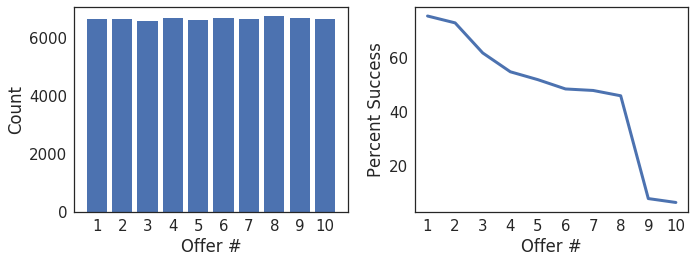

In [98]:
f, ax = plt.subplots(figsize=(10, 4), nrows=1,  ncols=2)
ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer #')
ax[0].set_ylabel('Count')

ax[1].plot(percent_success.index + 1, percent_success['percentsuccess'],linewidth=3)
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer #')
ax[1].set_ylabel('Percent Success')
plt.tight_layout()

# Split the data into training and testing data

In [99]:
random_state = 42

class_label_name='offersuccessful'

variables = clean_data.drop(columns=['offersuccessful','offer_id','totalamount'])
class_label = clean_data.filter([class_label_name])

class_label

,offersuccessful
0,1
1,0
2,0
3,0
4,1
5,0
6,0
7,0
8,0
9,1


In [100]:

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(variables.values,
                            class_label.values,
                            test_size=0.2,
                            random_state=random_state)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [101]:

variable_names = variables.columns


variable_names

Index(['duration', 'reward', 'bogo', 'discount', 'mobile', 'social', 'web',
       'F', 'M', 'O', 'income', '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)',
       '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)', '[90, 100)',
       '[100, 110)'],
      dtype='object')


## Predictive Modeling
Evaluate naive predictor performance, it assumes that all customer offers were successful

Assess the accuracy and F1-score of a naive model. This provides me a baseline for evaluating the performance of models. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight to its performance. Here F1-score metric is used because it is a weighted average of the precision and recall metrics.

F1 Score:

Since F-beta score is F1 with beta=1, I am weighting recall and precision as equally important.

The formula is given by the harmonic mean of precision and recall: F1 = 2PrecisionRecall/(Precision + Recall)



In [102]:

naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))



Naive predictor accuracy: 0.473
Naive predictor f1-score: 0.642


Intializing the model_performace for storing accuracy and f1_score

for different classifier type


In [103]:
model_performance = []

classifier_type = ['naivepredictor',
                   'logisticregression',
                   'randomforest',
                   'gradientboosting']
model_performance.append((naive_predictor_accuracy, naive_predictor_f1score))

We are droping  'duration','reward','mobile','social', 'web'  based subject knowledge we assume that these are not key factors to identify an offer will be  successfull or  not


In [104]:
training_variables = pd.DataFrame(X_train, columns=variable_names)
training_labels = pd.DataFrame(y_train, columns=[class_label_name])

training_data = pd.concat([
                           training_variables,
                           training_labels], axis=1)

training_data = training_data.drop(columns=[
                                            'duration',
                                            'reward',
                                            'mobile',
                                            'social',
                                            'web'])

training_data.head()


,bogo,discount,F,M,O,income,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)",offersuccessful
0,1.0,0.0,0.0,1.0,0.0,88000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,1.0,0.0,0.0,71000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,1.0,1.0,0.0,0.0,55000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,1.0,0.0,0.0,100000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,1.0,0.0,0.0,1.0,0.0,35000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [105]:
training_data.shape

(53200, 17)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


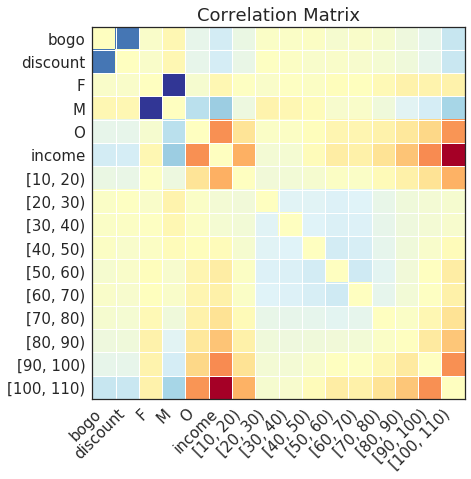

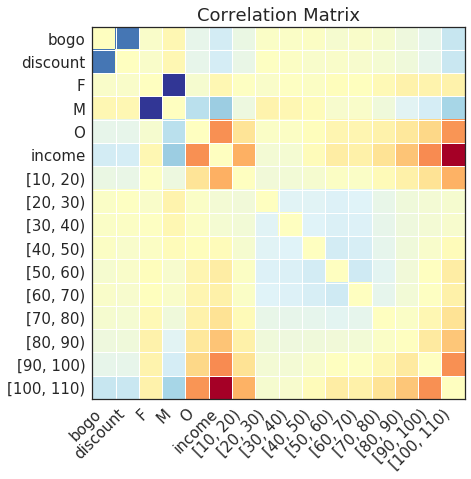

In [106]:
import statsmodels.graphics.correlation as pltcor
arr = training_data.drop(['offersuccessful'], axis = 1)
cols = list(arr)
arr = arr.as_matrix()
arr = preprocessing.scale(arr, axis = 1)
corrMat = np.corrcoef(arr, rowvar =0)
np.fill_diagonal(corrMat, 0)
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
pltcor.plot_corr(corrMat, xnames = cols, ax=ax)

In [107]:

test_variables = pd.DataFrame(X_test, columns=variable_names)
test_labels = pd.DataFrame(y_test, columns=[class_label_name])


test_data = pd.concat([test_variables, test_labels], axis=1)

test_data = test_data.drop(columns=[        
                                            'duration',
                                            'reward',                                            
                                            'mobile',
                                            'social',
                                            'web'])

test_data.head()

,bogo,discount,F,M,O,income,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)",offersuccessful
0,0.0,1.0,1.0,0.0,0.0,69000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,1.0,0.0,1.0,0.0,54000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,1.0,0.0,1.0,0.0,56000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,1.0,0.0,1.0,0.0,111000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,1.0,0.0,1.0,0.0,0.0,93000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [108]:
test_data.shape

(13301, 17)

In [109]:

sgd_clf = SGDClassifier(random_state=42, max_iter=10) # if you want reproducible results set the random_state value.
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [110]:
sgd_clf.predict([X_test[1]])

array([0])

In [111]:
y_test[1]

0

I tried SGDClassifier, but this actually used for NLP or image classification. Not a good fit for ours

I used 'logisticregression', 'randomforest' and 'gradientboosting'

In [112]:


def evaluate_model_performance(clf,
                               X_train,
                               y_train,
                              class_name):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix

        y_train: Expected model output vector
        
        class_name: Name of the class used for printing purpose
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
  
    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score



In [113]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [114]:
lr_model_path = os.path.join(model_dir, 'lr_clf.joblib')

scorer = make_scorer(fbeta_score,beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state,   solver='liblinear')

    random_grid = {'penalty': ['l1', 'l2'],'C': [1.0, 0.1, 0.01]}
    lr_random = RandomizedSearchCV(estimator = lr_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 6,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    lr_random.fit(X_train, y_train)
    dump(lr_random, lr_model_path)

In [115]:
evaluate_model_performance(lr_random.best_estimator_,   X_train, y_train,'LogisticRegression')

LogisticRegression model accuracy: 0.698
LogisticRegression model f1-score: 0.699


(0.6981015037593985, 0.69850387640554901)

In [116]:
model_performance.append(evaluate_model_performance(lr_random.best_estimator_, X_train,y_train,'LogisticRegression'))

LogisticRegression model accuracy: 0.698
LogisticRegression model f1-score: 0.699


In [117]:
rf_model_path = os.path.join(model_dir, 'rf_clf.joblib')
# Number of trees in random forest
n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)

   

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator = rf_clf,
                                       param_distributions = random_grid,
                                       scoring=scorer,
                                       n_iter = 100,
                                       cv = 3,
                                       verbose=2,
                                       random_state=random_state,
                                       n_jobs = 3)

    rf_random.fit(X_train, y_train)
    dump(rf_random,rf_model_path)

In [118]:
evaluate_model_performance(rf_random.best_estimator_,  X_train, y_train, 'RandomForestClassifier')

RandomForestClassifier model accuracy: 0.753
RandomForestClassifier model f1-score: 0.749


(0.7533082706766917, 0.74867866717732678)

In [119]:
model_performance.append(evaluate_model_performance(rf_random.best_estimator_,X_train,y_train,'RandomForestClassifier'))

RandomForestClassifier model accuracy: 0.753
RandomForestClassifier model f1-score: 0.749


Text(0.5,1,'Random Forest Estimated Feature Importance')

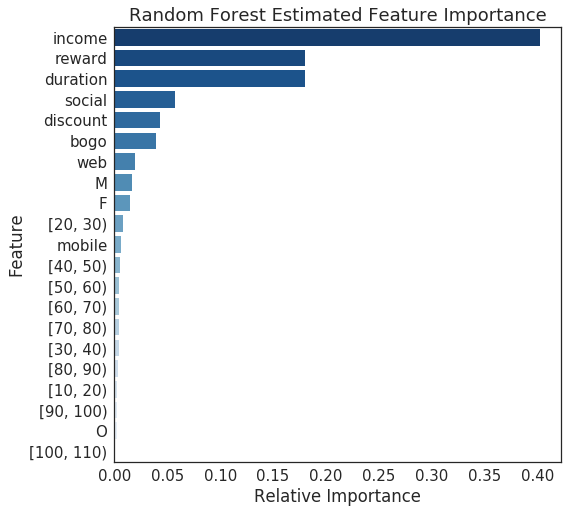

In [120]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =  pd.DataFrame(list(zip(variable_names, relative_importance)),  columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance', ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

In [121]:
feature_importance.head(n=10)

,feature,relativeimportance
0,income,0.402083
1,reward,0.180275
2,duration,0.179766
3,social,0.057174
4,discount,0.043376
5,bogo,0.038887
6,web,0.019413
7,M,0.017023
8,F,0.014633
9,"[20, 30)",0.008475


In [122]:
gb_model_path = os.path.join(model_dir, 'gb_clf.joblib')

if os.path.exists(gb_model_path):
    gb_random = load(gb_model_path)
else:
    gb_clf = GradientBoostingClassifier(random_state=random_state)

    # Create the random grid
    random_grid = {'loss': ['deviance', 'exponential'],
                       'learning_rate': [0.1, 0.01, 0.001],
                       'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split}

    gb_random = RandomizedSearchCV(estimator = gb_clf,
                                       param_distributions = random_grid,
                                       scoring=scorer,
                                       n_iter = 100,
                                       cv = 3,
                                       verbose=2,
                                       random_state=random_state,
                                       n_jobs = 3)
    gb_random.fit(X_train, y_train)
    dump(gb_random,gb_model_path)

In [123]:
evaluate_model_performance(gb_random.best_estimator_, X_train, y_train,'GradientBoostingClassifier')

GradientBoostingClassifier model accuracy: 0.712
GradientBoostingClassifier model f1-score: 0.714


(0.71225563909774436, 0.71378356143893495)

In [124]:



model_performance.append(evaluate_model_performance(gb_random.best_estimator_, X_train,y_train,'GradientBoostingClassifier'))

model_performance = pd.DataFrame(model_performance,columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type,columns=['model'])

model_performance = pd.concat([classifier_type, model_performance], axis=1)

model_performance = model_performance.sort_values('accuracy', ascending=False)
model_performance = model_performance.reset_index(drop=True)
model_performance

GradientBoostingClassifier model accuracy: 0.712
GradientBoostingClassifier model f1-score: 0.714


,model,accuracy,f1score
0,randomforest,0.753308,0.748679
1,gradientboosting,0.712256,0.713784
2,logisticregression,0.698102,0.698504
3,naivepredictor,0.472669,0.641922


Based on the performance  RandomForest is best model to train and use for prediction

In [125]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


Train the Randomforest using the best estimator

Random search used to narrow down the range for each hyperparameter. Now to concentrate our search, specify every combination of settings to try. Use this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations defined. To use Grid Search, we make another grid based on the best values provided by random search:

    What hyper-parameters were tuned?
        n_estimators ,max_features, min_samples_split , min_samples_leaf, random_state  are the parameters used here to tune the model
    
    What hyper-parameter values were tried out?
        Used some of the values
                        'n_estimators': [300, 350, 400, 450, 500]
                        'min_samples_leaf':[2, 5, 10]
                        'min_samples_split': [1, 2, 4]
                        max_features = ['auto', 'sqrt']
      
    What were some of the results?
                        Since it took long time to run (ie more than 2 hours ) didn't get a adequate results. So used best estimator paramters from the RandomizedSearchCV of random forest classifier is used.
                        those are 'n_estimators': [250]
                                  'min_samples_leaf': [4]
                                  'min_samples_split': [10]
                                  'max_features':['sqrt']
                                   random_state :42
                                    
    n_estimators = number of trees in the foreset
    min_samples_split = min number of data points placed in a node before the node is split
    min_samples_leaf = min number of data points allowed in a leaf node
    max_features = max number of features considered for splitting a node
    
    Using RandomSearchCV the result 
        RandomForestClassifier model accuracy: 0.753
        RandomForestClassifier model f1-score: 0.749

    

In [127]:
grid_fit_path = os.path.join(model_dir, 'grid_fit.joblib')

if os.path.exists(grid_fit_path):
    grid_fit = load(grid_fit_path)
else:
    parameters = {'n_estimators': [250],
                  'min_samples_leaf': [4],
                  'min_samples_split': [10],
                  'max_features':['sqrt'],
                  'random_state': [random_state]}
    rf_clf = RandomForestClassifier(random_state=random_state)

    grid_obj = GridSearchCV(rf_clf,
                            parameters,
                            scoring=scorer,
                            cv=5,
                            n_jobs=1,
                            verbose=0)

    grid_fit = grid_obj.fit(X_train,
                            y_train)

    dump(grid_fit, grid_fit_path)

# Get the estimator
best_clf = grid_fit.best_estimator_

evaluate_model_performance(best_clf, X_train, y_train,'BestGridFit')

BestGridFit model accuracy: 0.753
BestGridFit model f1-score: 0.749


(0.7533082706766917, 0.74867866717732678)

In [128]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Using the Random Forest Classfier test the data

In [129]:
evaluate_model_performance(best_clf, X_test, y_test,'BestGrid')

BestGrid model accuracy: 0.693
BestGrid model f1-score: 0.684


(0.69257950530035339, 0.68353842581843516)

# Conclusion

From the feature importance we see that individuals will respond to discount than buy one get one offer. Also Male is 
more likely to purchase than female. The Age group which is more responded to the offer is 20 to 30. Income is the most important
factor.Here I tried to conclude that for a particular demographics, if we gave a BOGO or discount whether it will be successfull or not. In order to conclude in the above statement I compared the performance of logistic regression, random forest, 
and gradient boosting models. From the analysis random forest is the best model in training which has the accuracy of .75 
and  f1_score of .74. When we used the test data for analysis the accuracy came to .69 and and f1_score to .68 which 
we can say that the model will not overfit our prediction.

Improvments can be made by adding some of the numerical features that describes a contribution to building a model that maximizes the evaluation(predication). A random forest classifier model estimates feature importance during training. customer offer effectiveness training data suggests that the some features based on their importance are: Offer duration, Offer reward ,Customer income .These additional features should provide a random forest classifier the opportunity to construct a better decision model. 

Cleansing the data is tedious job in this project that took more time espesially in combining all three databases and finding out the offer success. This is because the project time frame estimation to calculate offer success. Also GridSearchCV took long time to tune the model with more wide range of parameters. So this project used only the best esitmates

